In [1]:
file_path = 'logfile.log' # Asegúrate de que el nombre del archivo sea exacto

with open(file_path, 'r') as f:
    log_content = f.readlines()

# Ahora 'log_content' es una lista donde cada elemento es una línea del log
print(log_content[0]) # Imprime la primera línea para verificar

DMESG:



In [2]:
received_packets = []
for line in log_content:
    if (("[PKTS~][secondary_server-UP]" in line and '"rxpk"' in line) or ("[INFO~][PKTS][secondary_server-UP]" in line)):
        received_packets.append(line)

print(f"Se encontraron {len(received_packets)} líneas de paquetes recibidos del servidor secundario (sin estadísticas).")

Se encontraron 482 líneas de paquetes recibidos del servidor secundario (sin estadísticas).


In [3]:
import json
import re

info_packets = []     # (fcnt, linea INFO)
linked_packets = []   # {fcnt: ..., json: {...}}

last_fcnt = None

for line in log_content:
    # Línea tipo INFO (no JSON, contiene fcnt)
    if "[INFO~][PKTS][secondary_server-UP]" in line:
        match = re.search(r'fcnt[:=]\s*(\d+)', line)
        if match:
            last_fcnt = int(match.group(1))
            info_packets.append((last_fcnt, line))

    # Línea tipo PKTS con JSON válido (contiene rxpk)
    elif "[PKTS~][secondary_server-UP]" in line and '"rxpk"' in line:
        try:
            data = json.loads(line[line.find("{"):line.rfind("}")+1])
            if last_fcnt is not None:
                linked_packets.append({"fcnt": last_fcnt, "json": data})
        except Exception:
            pass

print(f"Se encontraron {len(info_packets)} mensajes INFO (con fcnt).")
print(f"Se enlazaron {len(linked_packets)} JSON con su fcnt correspondiente.")

Se encontraron 241 mensajes INFO (con fcnt).
Se enlazaron 241 JSON con su fcnt correspondiente.


In [4]:
linked_packets

[{'fcnt': 929,
  'json': {'rxpk': [{'jver': 1,
     'tmst': 1700974784,
     'time': '2025-08-20T21:19:42.914106Z',
     'chan': 5,
     'rfch': 1,
     'freq': 914.5,
     'mid': 8,
     'stat': 1,
     'modu': 'LORA',
     'datr': 'SF7BW125',
     'codr': '4/5',
     'rssis': -9,
     'lsnr': 13.8,
     'foff': 2492,
     'rssi': -9,
     'size': 121,
     'data': 'QCmyDCYAoQMBO1UMzCe+cPcjYSbfOzN1PwP/l96vrk669Se3gGLR3kFAxuS8PhBtvNAy996RVkD5+bB7k9hKqV0OEFsxvlRXzfmP6T7KVCHvCl9Ghc8euAeuc2K1Z3MnJHmAElQz6MTlIrlJWAjrzsWJY9CuPhexJg=='}]}},
 {'fcnt': 930,
  'json': {'rxpk': [{'jver': 1,
     'tmst': 1703881522,
     'time': '2025-08-20T21:19:45.819569Z',
     'chan': 3,
     'rfch': 0,
     'freq': 914.1,
     'mid': 8,
     'stat': 1,
     'modu': 'LORA',
     'datr': 'SF7BW125',
     'codr': '4/5',
     'rssis': -18,
     'lsnr': 14.0,
     'foff': 2528,
     'rssi': -17,
     'size': 171,
     'data': 'QCmyDCYAogMBUFkIM88AG/8oVF533d9pi5S+pBR56Zs20Sjxu4rsbLCT+YM+JCrQ9EGocIBjSZ7sopcjvTFUneE

In [17]:
import pandas as pd

data = []

for packet in linked_packets:
    fcnt = packet['fcnt']
    rxpk = packet['json']['rxpk'][0]  # Asumimos que siempre hay un elemento en 'rxpk'
    time = rxpk['time']
    freq = rxpk['freq']
    size = rxpk['size']

    data.append({
        'fcnt': fcnt,
        'time': time,
        'freq': freq,
        'size': size
    })

# Crear el DataFrame
df = pd.DataFrame(data)

# Agregar la nueva columna 'tipo' basada en el tamaño del mensaje
df['type'] = df['size'].apply(lambda x: 'voltage' if x == 171 else ('current' if x == 121 else 'battery'))


# Mostrar el DataFrame
print(df)

     fcnt                         time   freq  size     type
0     929  2025-08-20T21:19:42.914106Z  914.5   121  current
1     930  2025-08-20T21:19:45.819569Z  914.1   171  voltage
2     931  2025-08-20T21:19:57.915346Z  913.9   121  current
3     932  2025-08-20T21:20:00.823971Z  913.7   171  voltage
4     933  2025-08-20T21:20:12.916222Z  914.7   121  current
..    ...                          ...    ...   ...      ...
236  1165  2025-08-20T21:45:57.924938Z  913.7   121  current
237  1166  2025-08-20T21:46:00.837061Z  913.9   171  voltage
238  1167  2025-08-20T21:46:12.928122Z  914.3   121  current
239  1168  2025-08-20T21:46:15.832343Z  914.7   171  voltage
240  1169  2025-08-20T21:46:18.487463Z  914.3    22  battery

[241 rows x 5 columns]


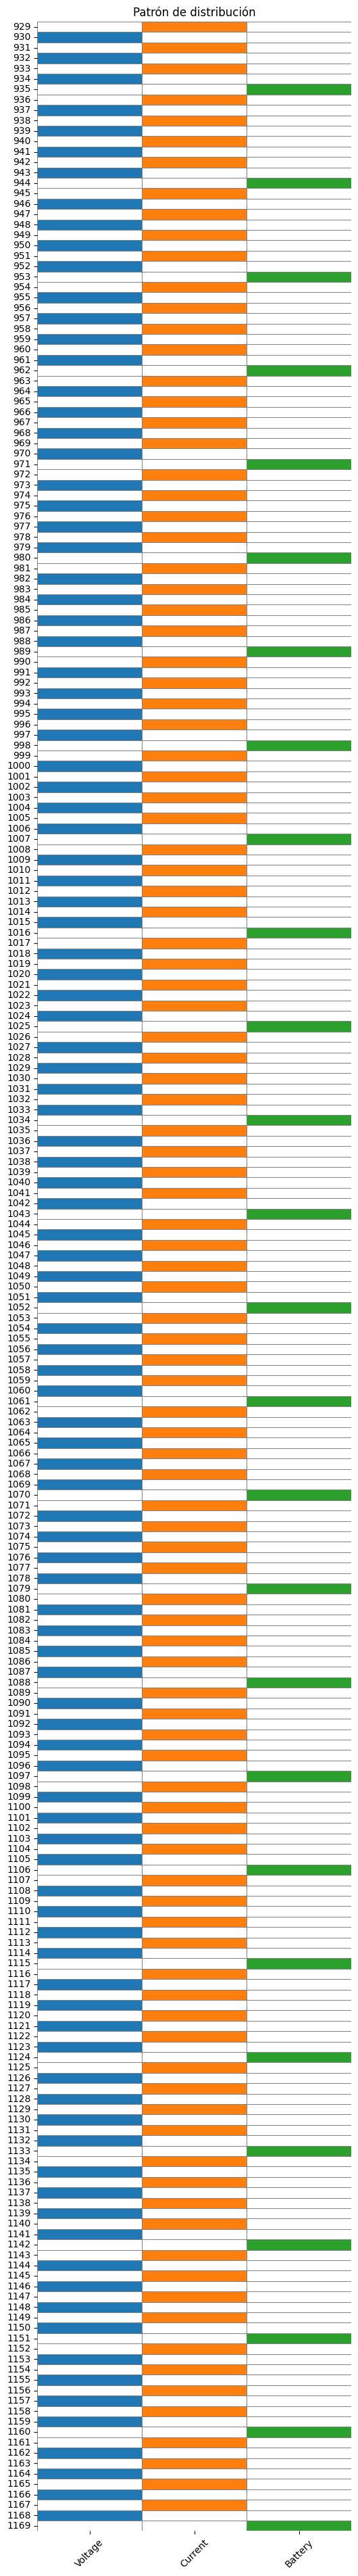

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Mapear a columnas fijas:
# Columna 0 = voltage, 1 = current, 2 = battery
type_mapping = {'voltage': 0, 'current': 1, 'battery': 2}
df['col'] = df['type'].map(type_mapping)

# Construir matriz con NaN donde no toca
n_rows = len(df)
n_cols = 3
matrix = np.full((n_rows, n_cols), np.nan)

for i, (_, row) in enumerate(df.iterrows()):
    matrix[i, row['col']] = row['col']  # valor simbólico para el heatmap

# ---- 🔹 Graficar ----
cmap = sns.color_palette(["#1f77b4", "#ff7f0e", "#2ca02c"])  # azul, naranja, verde

plt.figure(figsize=(6, n_rows/5))
sns.heatmap(matrix, cmap=cmap, cbar=False, linewidths=0.5, linecolor='gray')

plt.yticks(np.arange(n_rows)+0.5, df['fcnt'], rotation=0)
plt.xticks(np.arange(3)+0.5, ["Voltage", "Current", "Battery"], rotation=45)

plt.title("Patrón de distribución")
plt.show()
